# Эксперименты по восстановлению профилей дисперсий в трех направлениях для NGC2273 (UGC3546)

Сначала всякие настройки и импорты

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
from IPython.display import HTML
from IPython.display import Image
import os
import pandas as pd
import heapq
from numpy import poly1d, polyfit, power
import math
from math import *
%matplotlib inline

#Размер изображений
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 12, 12

#Наклон галактики по данным Засова
incl=55.0

# Масштаб пк/секунда из NED
scale=138

Всякие картинки и БД для большего удобства:

In [2]:
# Нет данных из SDSS DR9
HTML('<iframe src=http://skyserver.sdss3.org/dr9/en/tools/explore/obj.asp?ra=06:50:08.6&dec=+60:50:45 width=1000 height=350></iframe>')

In [3]:
# Данные из HYPERLEDA
HTML('<iframe src=http://leda.univ-lyon1.fr/ledacat.cgi?o=ngc2273 width=1000 height=350></iframe>')

In [4]:
# Данные из NED
HTML('<iframe src=http://ned.ipac.caltech.edu/cgi-bin/objsearch?objname=ngc+2273&extend=no&hconst=73&omegam=0.27&omegav=0.73&corr_z=1&out_csys=Equatorial&out_equinox=J2000.0&obj_sort=RA+or+Longitude&of=pre_text&zv_breaker=30000.0&list_limit=5&img_stamp=YES width=1000 height=350></iframe>')

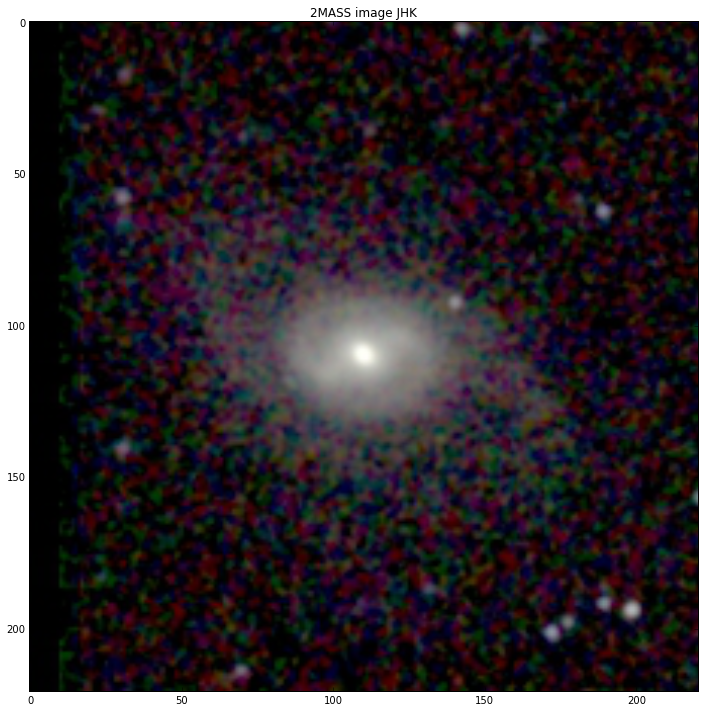

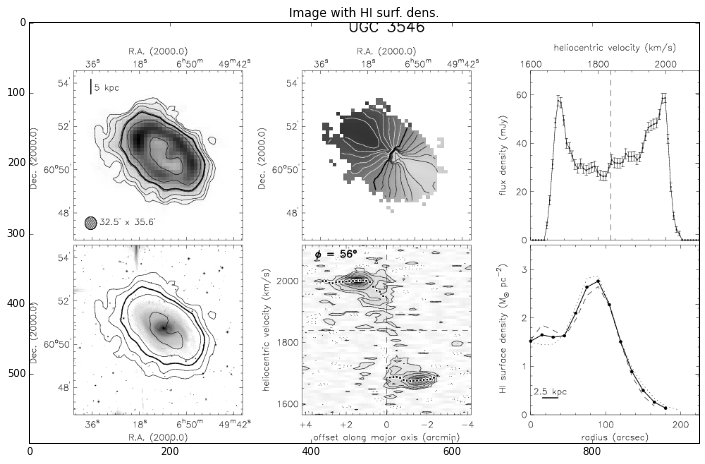

In [5]:
os.chdir("C:\\science\\2FInstability\\data\\ngc2273")

#Изображения, которые имеют отношение
try:
    from PIL import Image
except:
    import Image

plt.imshow(np.asarray(Image.open("ngc2273_JHK.jpg")))
plt.title("2MASS image JHK")
plt.show()

plt.imshow(np.asarray(Image.open("ugc3546.png")))
plt.title("Image with HI surf. dens.")
plt.show()

In [6]:
#Выводим данные за header-а файла
for line in file("v_stars_maZ.dat"):
    if line[0] == '#':
        print(line)

# UGC 3546 = NGC 2273

# Zasov+08

# PA = 58 deg

# not corrected for V_sys

# inclination = 55 deg (adopted by Noordermeer+2007)

# data ARE NOT corrected for inclination

# SSBS_FUL: Cross correlation with star HD73471.ln

# Original spectra:n2273ma.ln

#  r"      v     dv  sig(TD)  dsig



Выведем также для удобства данные из обоих файлов: 

In [7]:
ma = pd.read_csv('v_stars_maZ.dat', skiprows=9, header=False)
# HTML(ma.to_html())

In [8]:
mi = pd.read_csv('v_stars_miZ.dat', skiprows=9, header=False)
# HTML(mi.to_html())

Посмотрим теперь на все доступные даные по кривым вращения.

[]

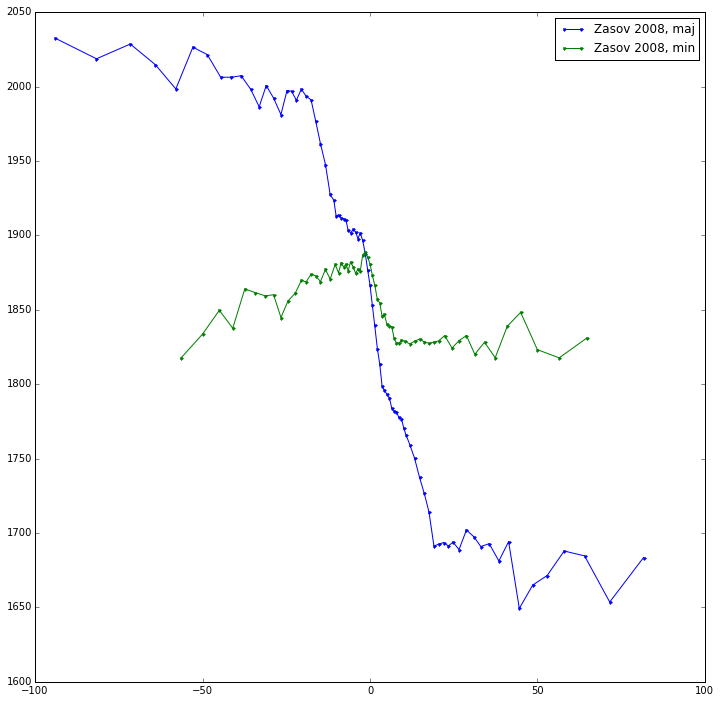

In [9]:
# Данные по звездной кинематике Засова 2008 вдоль большей полуоси, не исправленные за наклон 
zasov_raw_data = np.loadtxt("v_stars_maZ.dat", float)
r_ma, vel_ma, e_vel_ma, sig_ma, e_sig_ma = zip(*zasov_raw_data)

# Данные по звездной кинематике Засова 2008 вдоль малой полуоси, не исправленные за наклон 
zasov_raw_data = np.loadtxt("v_stars_miZ.dat", float)
r_mi, vel_mi, e_vel_mi, sig_mi, e_sig_mi = zip(*zasov_raw_data)

# Данные по кинематике газа Noordermeer 2007 (исправлено за наклон)
wsrt_raw_data = np.loadtxt("v_gas_WSRT.dat", float)
r_wsrt, vel_wsrt, e_vel_wsrt = zip(*wsrt_raw_data)

plt.plot(r_ma, vel_ma, '.-', label="Zasov 2008, maj")
plt.plot(r_mi, vel_mi, '.-', label="Zasov 2008, min")
plt.legend()
plt.plot()

[]

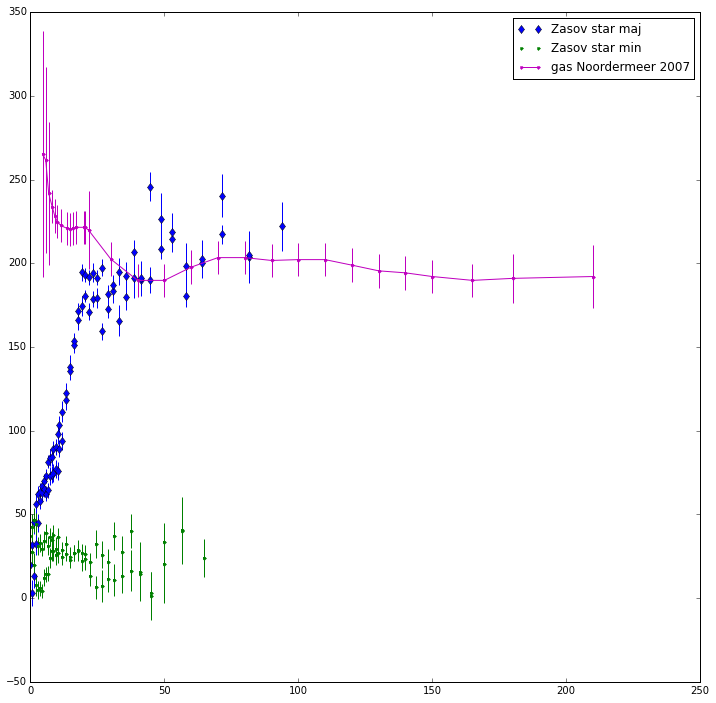

In [10]:
def incline_velocity(v, angle):
    return v / sin(angle * pi / 180)

# Переносит центр в (r0,v0) и перегибает кривую вращения, 
# а также исправляет за наклон если необходимо
def correct_rotation_curve(rdata, vdata, dvdata, r0, v0, incl):
    rdata_tmp = [abs(r-r0) for r in rdata]
    vdata_tmp = [incline_velocity(abs(v-v0), incl) for v in vdata]
    data = zip(rdata_tmp, vdata_tmp, dvdata)
    data.sort()
    return zip(*data)

r_ma_b, vel_ma_b, e_vel_b = correct_rotation_curve(r_ma, vel_ma, e_vel_ma,  0.0, 1850.6, incl)
r_mi_b, vel_mi_b, e_vel_mi_b = correct_rotation_curve(r_mi, vel_mi, e_vel_mi,  0.0, 1850.6, incl)

plt.plot(r_ma_b, vel_ma_b, 'd', label = 'Zasov star maj')
plt.errorbar(r_ma_b, vel_ma_b, yerr=e_vel_b, fmt='.', marker='.', mew=0, color='blue')
plt.plot(r_mi_b, vel_mi_b, '.', label = 'Zasov star min', color='green')
plt.errorbar(r_mi_b, vel_mi_b, yerr=e_vel_mi_b, fmt='.', marker='.', mew=0, color='green')
plt.plot(r_wsrt, vel_wsrt, '.-', label="gas Noordermeer 2007", color='m')
plt.errorbar(r_wsrt, vel_wsrt, yerr=e_vel_wsrt, fmt='.', marker='.', mew=0, color='m')
plt.legend()
plt.plot()

В дальнейшем используем только засовские данные по звездам по большой полуоси, приблизим их полиномом. 

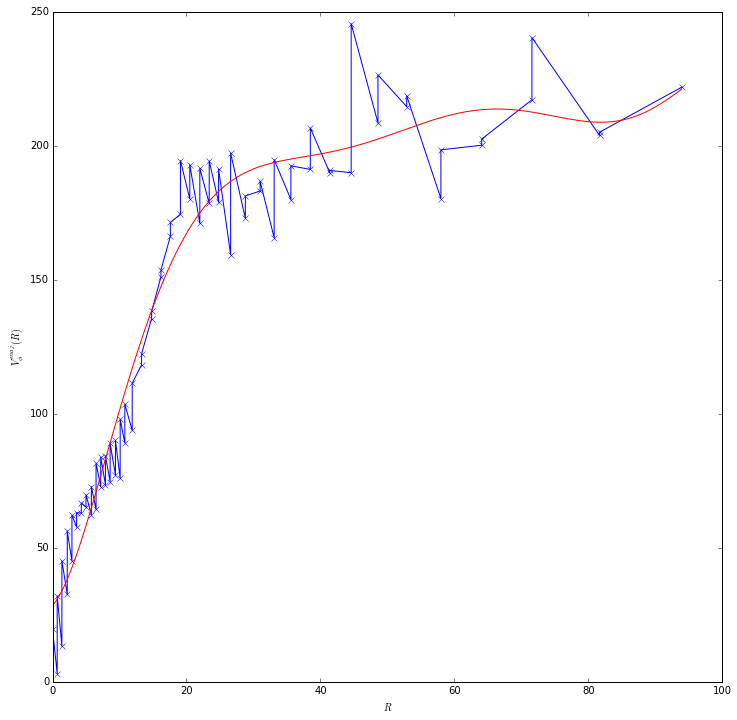

In [11]:
poly_star = poly1d(polyfit(r_ma_b, vel_ma_b, deg=7))

plt.plot(r_ma_b, vel_ma_b, 'x-', color='blue', markersize=6)
test_points = np.arange(0.0, max(r_ma_b), 0.1)
plt.plot(test_points, poly_star(test_points), '-', color='red')
plt.xlabel('$R$'); plt.ylim(0)
plt.ylabel('$V^{maj}_{\phi}(R)$')
plt.show()

In [12]:
os.chdir("C:\\Users\\root\\Dropbox\\RotationCurves\\PhD\\paper1\\text\\imgs")

np.save('n2273_maj_rot', zip(r_ma_b, vel_ma_b, e_vel_b))
np.save('n2273_rot_poly', zip(test_points, poly_star(test_points)))

os.chdir("C:\\science\\2FInstability\\data\\ngc2273")

Кривая вращения нам нужна для нахождения соотношения $\sigma_{\varphi}^{2}/\sigma_{R}^{2}$, которое описывается уравнением ${\displaystyle \sigma_{\varphi}^{2}/\sigma_{R}^{2}=0.5\left(1+\frac{R}{\bar{v}_{\varphi}}\frac{d\bar{v}_{\varphi}}{dR}\right)}$ (Binney & Tremaine, 1987) и приближается гладко функцией $f=0.5(1+e^{-R/R_{0}}),$ где $R_{0}$ --- характерный масштаб. 

${\bf Примечание:}$ Такое приближение оправдано следующими соображениями. Для равновесного диска верно уравнение, описанное выше. Для твердотельного участка вращения в центральных областях выражение в скобках равно 2, а $\sigma_{\varphi}^{2}/\sigma_{R}^{2}=1$. На плоском участке кривой вращения на периферии диска $\sigma_{\varphi}^{2}/\sigma_{R}^{2}\thickapprox0.5$. Функция $f$ как раз аппроксимирует такое поведение отношения $\sigma_{\varphi}^{2}/\sigma_{R}^{2}$.

Изобразим получившийся профиль $\sigma_{\varphi}^{2}/\sigma_{R}^{2}$, вычисляемый через производную полинома:

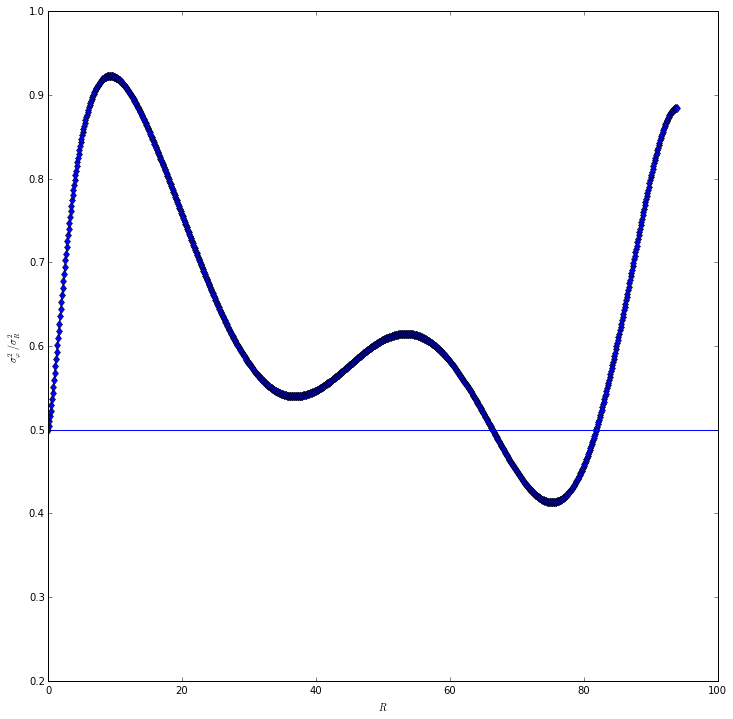

In [12]:
def sigPhi_to_sigR_real(R):
        return 0.5 * (1 + R*poly_star.deriv()(R) / poly_star(R))

plt.plot(test_points, [sigPhi_to_sigR_real(R) for R in test_points], 'd-', color='blue')
plt.axhline(y=0.5)
plt.axhline(y=0.0)
plt.xlabel('$R$')
plt.ylabel(r"$\sigma_{\varphi}^2/\sigma_{R}^2$")
plt.ylim(0.2)
plt.show()

Найдем теперь характерный масштаб $f=0.5(1+e^{-R/R_{0}})$:

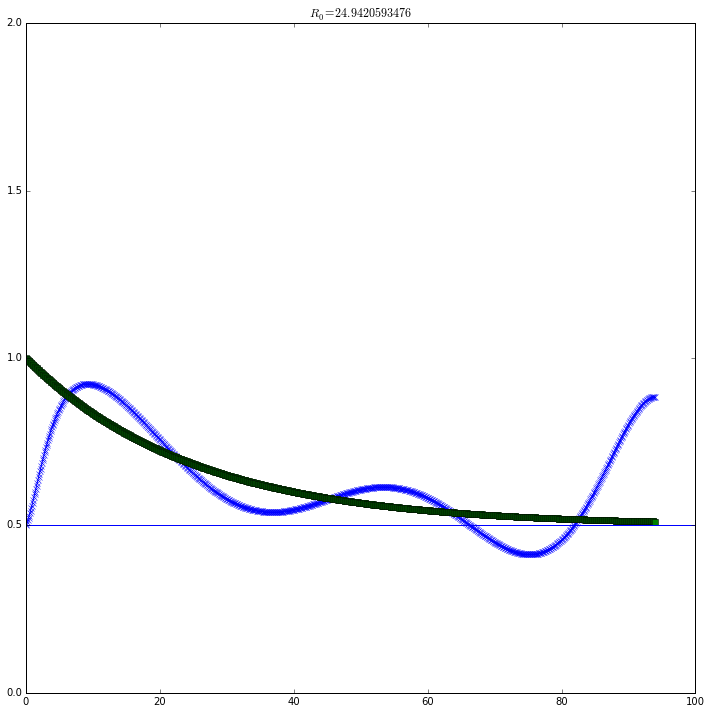

In [13]:
def f(R, Ro):
    return 0.5*(1 + np.exp( -R/Ro ))

xdata = test_points
ydata = sigPhi_to_sigR_real(xdata)

from scipy.optimize import curve_fit
popt, pcov = curve_fit(f, xdata, ydata, p0=[1.0])
Ro = popt[0]

plt.plot(xdata, ydata, 'x-')
plt.plot(xdata, [f(p, Ro) for p in xdata], 's')
plt.axhline(y=0.5)
plt.axhline(y=0.0)
plt.title('$R_{0} = %s $' % Ro)
plt.ylim(0, 2)
plt.show()

Теперь знаем значение отношения $\sigma_{\varphi}^{2}/\sigma_{R}^{2}$ в любой точке, заведем соответствующую функцию:

In [14]:
def sigPhi_to_sigR(R):
    return sqrt(f(R, Ro))

Построим графики дисперсий скоростей на луче зрения вдоль большой и малой оси ($\sigma_{los}^{maj}$ и $\sigma_{los}^{min}$):

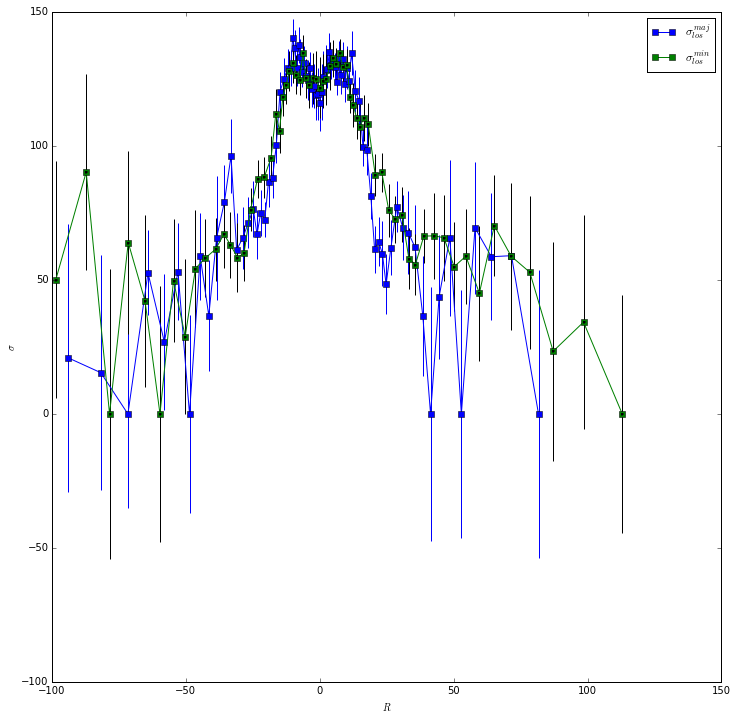

In [15]:
# Исправляем значения вдоль малой оси на синус угла:    
def correct_min(R):    
    return R / cos(incl * pi / 180) 

r_mi_extend = map(correct_min, r_mi)
    
plt.plot(r_ma, sig_ma, 's-', label='$\sigma_{los}^{maj}$')
plt.errorbar(r_ma, sig_ma, yerr=e_sig_ma, fmt='.', marker='.', mew=0, color='blue')
plt.plot(r_mi_extend, sig_mi, 's-', label='$\sigma_{los}^{min}$')
plt.errorbar(r_mi_extend, sig_mi, yerr=e_sig_mi, fmt='.', marker='.', mew=0, color='black')
plt.xlabel('$R$')
plt.ylabel('$\sigma$')
plt.legend()
plt.show()

Видно, что есть плохие нулевые точки, которые могут все испортить. Выкинем их, а затем перегнем и приблизим полиномами:

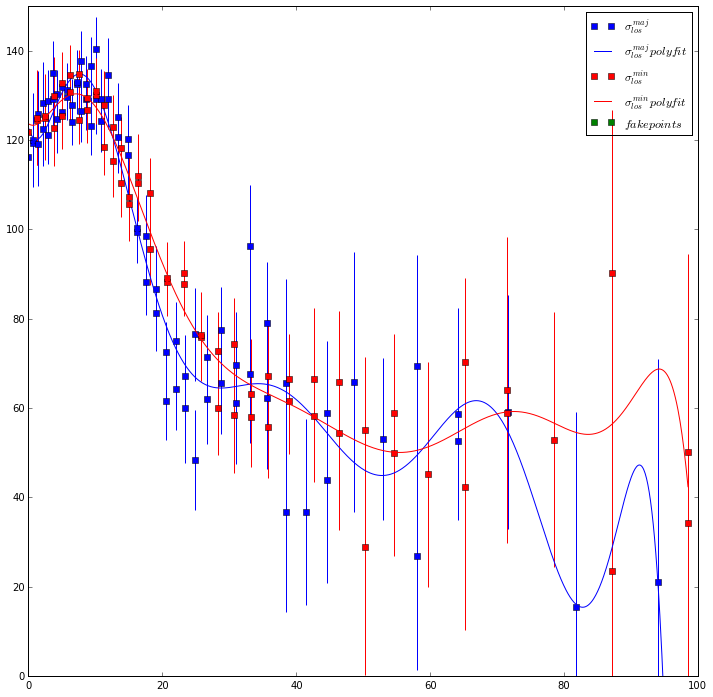

In [16]:
bind_curve = lambda p: (abs(p[0]), abs(p[1]), p[2])
sig_maj_data = zip(r_ma, sig_ma, e_sig_ma)
sig_maj_data = filter(lambda x: x[1] > 0, sig_maj_data)
sig_maj_data = map(bind_curve, sig_maj_data)
sig_maj_data.sort()
radii_maj, sig_maj_p, e_sig_maj_p = zip(*sig_maj_data) 

# Добавляем лишние точки чтобы протянуть дальше
num_fake_points = 10; expscale = 200.0
# fake_radii, fake_sig = zip(*[(31.0 + i, 115*exp(- i / expscale )) for i in range(1, num_fake_points+1)])
fake_radii, fake_sig = (),()

poly_sig_maj = poly1d(polyfit(radii_maj + fake_radii, sig_maj_p + fake_sig, deg=9))

sig_min_data = zip(r_mi_extend, sig_mi, e_sig_mi)
sig_min_data = filter(lambda x: x[1] > 0, sig_min_data)
sig_min_data = map(bind_curve, sig_min_data)
sig_min_data.sort()
radii_min, sig_min_p, e_sig_min_p = zip(*sig_min_data) 

poly_sig_min = poly1d(polyfit(radii_min, sig_min_p, deg=9))

points = np.arange(0, max(radii_min), 0.1)
plt.plot(radii_maj, sig_maj_p, 's', label='$\sigma_{los}^{maj}$', color='blue')
plt.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='.', marker='.', mew=0, color='blue')
plt.plot(points, poly_sig_maj(points), label = '$\sigma_{los}^{maj} polyfit$', color='blue')
plt.plot(radii_min, sig_min_p, 's', label='$\sigma_{los}^{min}$', color='red')
plt.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, fmt='.', marker='.', mew=0, color='red')
plt.plot(points, poly_sig_min(points), label = '$\sigma_{los}^{min} polyfit$', color='red')
plt.plot(fake_radii, fake_sig, 'bs', color='green', label='$fake points$')
plt.legend()
plt.ylim(0,150)
# plt.xlim(0,55)
plt.show()

Посчитаем величину невязок для полученного приближения:

In [17]:
sqerr_maj = sum(power([poly_sig_maj(p[0]) - p[1] for p in sig_maj_data], 2))
sqerr_min = sum(power([poly_sig_min(p[0]) - p[1] for p in sig_min_data], 2))

print "Poly chi^2 for maj = %s, mean = %s" % (sqerr_maj, sqerr_maj / sig_maj_p.__len__())
print "Poly chi^2 for min = %s, mean = %s" % (sqerr_min, sqerr_min / sig_min_p.__len__())

Poly chi^2 for maj = 6414.44799093, mean = 85.5259732123
Poly chi^2 for min = 4639.84101179, mean = 73.6482700285


Как видим, работать корректно с такими дисперсиями невозможно. Попробуем приблизить кривыми Безье:

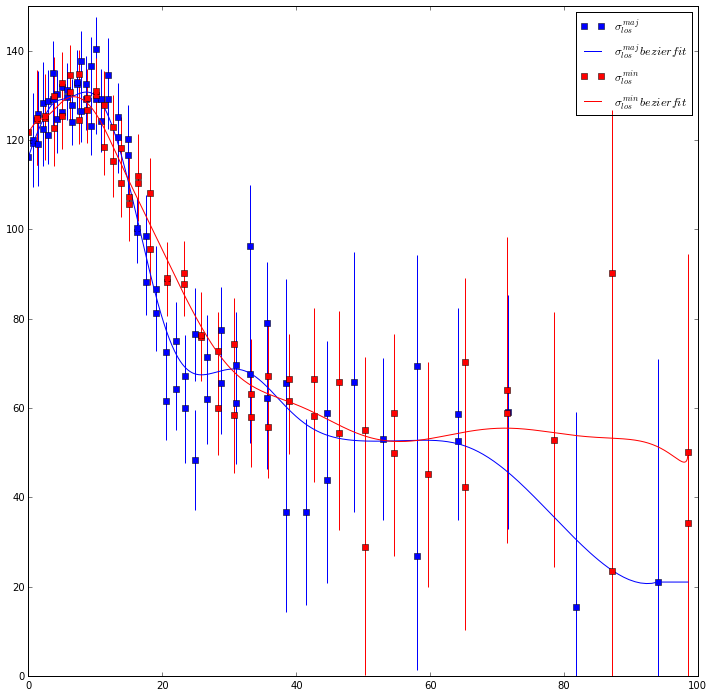

In [18]:
from scipy.misc import comb

def bernstein_poly(i, n, t):
    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i

def bezier_curve(points, nTimes=1000):
    nPoints = len(points)
    xPoints = np.array([p[0] for p in points])
    yPoints = np.array([p[1] for p in points])
    t = np.linspace(0.0, 1.0, nTimes)
    polynomial_array = np.array([ bernstein_poly(i, nPoints-1, t) for i in range(0, nPoints) ])
    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)
    return lambda xxx: np.interp(xxx, xvals[::-1], yvals[::-1])

bez_sig_maj = bezier_curve(zip(radii_maj, sig_maj_p), nTimes=1000)
bez_sig_min = bezier_curve(zip(radii_min, sig_min_p), nTimes=1000)

plt.plot(radii_maj, sig_maj_p, 's', label='$\sigma_{los}^{maj}$', color='blue')
plt.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='.', marker='.', mew=0, color='blue')
plt.plot(points, bez_sig_maj(points), label = '$\sigma_{los}^{maj} bezierfit$', color='blue')
plt.plot(radii_min, sig_min_p, 's', label='$\sigma_{los}^{min}$', color='red')
plt.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, fmt='.', marker='.', mew=0, color='red')
plt.plot(points, bez_sig_min(points), label = '$\sigma_{los}^{min} bezierfit$', color='red')
plt.legend()
plt.ylim(0,150)
plt.show()

Посчитаем величину невязок для полученного приближения кривыми Безье:

In [19]:
sqerr_maj_b = sum(power([bez_sig_maj(p[0]) - p[1] for p in sig_maj_data], 2))
sqerr_min_b = sum(power([bez_sig_min(p[0]) - p[1] for p in sig_min_data], 2))

print "Poly chi^2 for maj = %s, mean = %s" % (sqerr_maj_b, sqerr_maj_b / sig_maj_p.__len__())
print "Poly chi^2 for min = %s, mean = %s" % (sqerr_min_b, sqerr_min_b / sig_min_p.__len__())

Poly chi^2 for maj = 5628.62908489, mean = 75.0483877985
Poly chi^2 for min = 4846.43722507, mean = 76.9275750011


In [20]:
#Переопределим приближение, чтобы не переписывать код.
poly_sig_maj = bez_sig_maj
poly_sig_min = bez_sig_min

Также посмотрим, насколько хорошее приближение кривыми Безье у гнуплота:

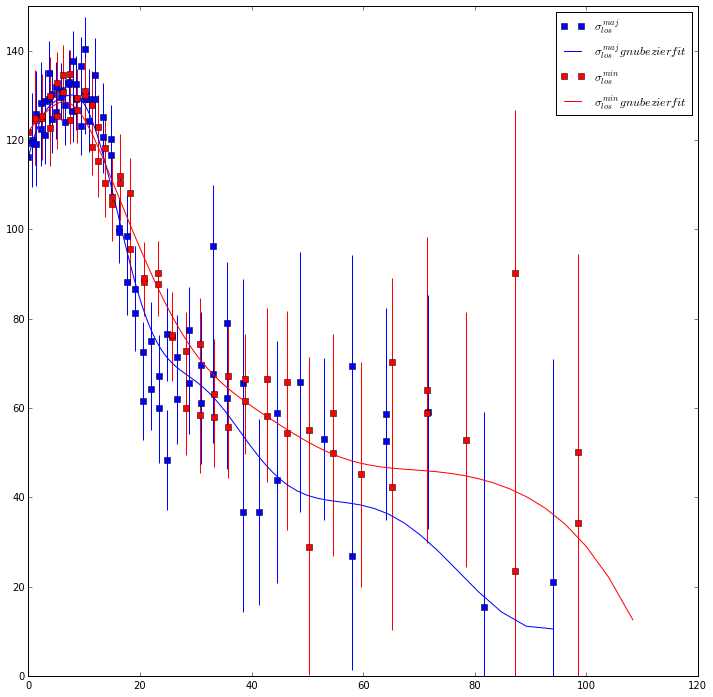

In [21]:
os.chdir("C:\\science\\2FInstability\\data\\ngc2273\\n2273_sbezier")

gnuplot_bezier_maj_data = np.loadtxt("smaj.dat", float)
gnu_r, gnu_maj = zip(*gnuplot_bezier_maj_data)

gnuplot_bezier_min_data = np.loadtxt("smin.dat", float)
gnu_r_mi, gnu_min = zip(*gnuplot_bezier_min_data)

plt.plot(radii_maj, sig_maj_p, 's', label='$\sigma_{los}^{maj}$', color='blue')
plt.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='.', marker='.', mew=0, color='blue')
plt.plot(gnu_r, gnu_maj, label = '$\sigma_{los}^{maj} gnubezierfit$', color='blue')
plt.plot(radii_min, sig_min_p, 's', label='$\sigma_{los}^{min}$', color='red')
plt.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, fmt='.', marker='.', mew=0, color='red')
plt.plot(gnu_r_mi, gnu_min, label = '$\sigma_{los}^{min} gnubezierfit$', color='red')
plt.legend()
plt.ylim(0,150)
plt.show()

Выглядит конечно все равно ужасно, но с такими профилями хотя бы можно работать. Подгоним их полиномами и переопределим.

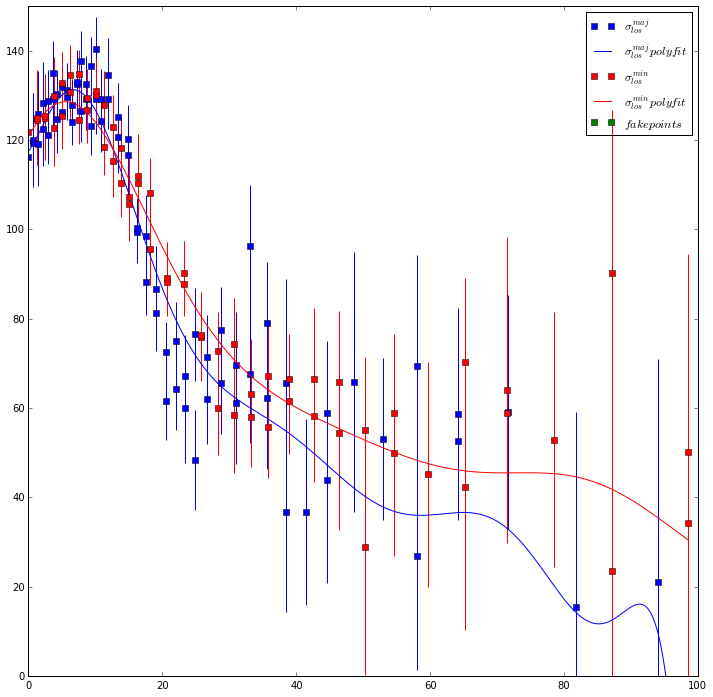

In [22]:
poly_sig_maj = poly1d(polyfit(gnu_r, gnu_maj, deg=9))
poly_sig_min = poly1d(polyfit(gnu_r_mi, gnu_min, deg=9))

points = np.arange(0, max(radii_min), 0.1)
plt.plot(radii_maj, sig_maj_p, 's', label='$\sigma_{los}^{maj}$', color='blue')
plt.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='.', marker='.', mew=0, color='blue')
plt.plot(points, poly_sig_maj(points), label = '$\sigma_{los}^{maj} polyfit$', color='blue')
plt.plot(radii_min, sig_min_p, 's', label='$\sigma_{los}^{min}$', color='red')
plt.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, fmt='.', marker='.', mew=0, color='red')
plt.plot(points, poly_sig_min(points), label = '$\sigma_{los}^{min} polyfit$', color='red')
plt.plot(fake_radii, fake_sig, 'bs', color='green', label='$fake points$')
plt.legend()
plt.ylim(0,150)
plt.show()

In [23]:
os.chdir("C:\\Users\\root\\Dropbox\\RotationCurves\\PhD\\paper1\\text\\imgs")

np.save('n2273_maj', zip(radii_maj, sig_maj_p, e_sig_maj_p))
np.save('n2273_min', zip(radii_min, sig_min_p, e_sig_min_p))
np.save('n2273_min_poly', zip(points, poly_sig_min(points)))
np.save('n2273_maj_poly', zip(points, poly_sig_maj(points)))

os.chdir("C:\\science\\2FInstability\\data\\ngc2273")

In [40]:
sqerr_maj = sum(power([poly_sig_maj(p[0]) - p[1] for p in sig_maj_data], 2))
sqerr_min = sum(power([poly_sig_min(p[0]) - p[1] for p in sig_min_data], 2))

print "Poly chi^2 for maj = %s, mean = %s" % (sqerr_maj, sqerr_maj / sig_maj_p.__len__())
print "Poly chi^2 for min = %s, mean = %s" % (sqerr_min, sqerr_min / sig_min_p.__len__())

Poly chi^2 for maj = 9787.43309252, mean = 130.4991079
Poly chi^2 for min = 6387.03573567, mean = 101.381519614


Методика восстановления профилей $\sigma_{R}(R)$, $\sigma_{\varphi}(R)$ и $\sigma_{z}(R)$ следующая. Представим, что $\sigma_{Z}/\sigma_{R} \equiv \alpha \equiv const$. Тогда, зная значения $\sigma_{\varphi}^{2}/\sigma_{R}^{2}=f(R)$ в каждой точке, получаем из уравнений, описанных выше: $$\sigma_{los,maj}^2=\sigma_R^2[f\sin^2i+\alpha^2\cos^2i]$$ $$\sigma_{los,min}^2=\sigma_R^2[\sin^2i+\alpha^2\cos^2i]$$
Представим теперь $\sigma_R(R)=\sigma_{R,0}\times F(R)$, где $F(0)=1$. Значение в квадратных скобках для $\sigma_{los,min}$ равно константе и, следуя предположению, получаем представление для дисперсии вдоль луча зрения для малой оси как $\sigma_{los,min}(R)=\sigma_{min,0}\times F(R)$. Очевидно $\sigma_{min,0} = \sigma_{los,min}(0)$, а значит мы знаем в каждой точке значение $F(R)=\sigma_{los,min(R)}/\sigma_{min,0}$. Описанная выше система уравнений вырождается в следующую:
$$\sigma_{los,maj}^2(R)=\frac{\sigma_{R,0}^2\sigma_{los,min}^2(R)[f\sin^2i+\alpha^2\cos^2i]}{\sigma_{min,0}^2}$$ $$\sigma_{min,0}^2=\sigma_{R,0}^2\sin^2i+\sigma_{R,0}^2\alpha^2\cos^2i$$
Сделаем замену: $\sigma_{R,0}^2\sin^2 i \equiv A,\ \sigma_{R,0}^2\cos^2 i\times \alpha^2 \equiv B$. Окончательно, имеем $N+1$ линейное уравнение для $N$ точек, которые можем решить МНК: 
$$\left\{
  \begin{array}{lr}
    \sigma_{los,maj}^2(R_j)\times \sigma_{min,0}^2 =\sigma_{los,min}^2(R_j)[Af(R_j)+B]\\
    \sigma_{min,0}^2=A+B
  \end{array}
\right.
$$

In [41]:
#Обрезаем данные по x > r_eff
r_eff = 0.0

#Значение sig_los_min в 0
sig_min_0 = poly_sig_min(0)

#Правая граница
r_max =95.0

#Количество точек N и сами точки
N = 50
radii_points = np.arange(r_eff, r_max, (r_max-r_eff)/N)

#Как вычислять ошибку 
def residuals(params, xdata, ydata):
            return (ydata - np.dot(xdata, params))

#Начальное приближение (А,В)
x0 = [1000, 100]

#Уравнения:  одно для min и N для maj
#Левая часть:
eq_left = np.concatenate( ([sig_min_0**2], 
                              [poly_sig_maj(p)**2 * sig_min_0**2  for p in radii_points]) )
#Правая часть:
eq_right = np.transpose(
            np.array([
                np.concatenate(([1.0],
                                   [poly_sig_min(R)**2 * sigPhi_to_sigR(R)**2 for R in radii_points])),
                np.concatenate(([1.0],
                                   [poly_sig_min(R)**2 for R in radii_points]))]))

# Что будет, если выкинуть уравнение для min:
# eq_left = np.array([poly_sig_maj(p)**2 * sig_min_0**2  for p in radii_points])
# eq_right = np.transpose(
#             np.array([[poly_sig_min(R)**2 * sigPhi_to_sigR(R)**2 for R in radii_points],
#                                    [poly_sig_min(R)**2 for R in radii_points]]))

# МНК для получившихся уравнений:
solution = scipy.optimize.leastsq(residuals, x0, args=(eq_right, eq_left))[0]
A, B = solution[0], solution[1]

chi2 = sum(power(residuals(solution, eq_right, eq_left), 2))/N
        
print 'Solution: A = %s, B = %s' % (A, B)
print 'Chi^2:', chi2

#Подставить в уравнение в какой-нибудь точке:
# rrr = 25.0
# print (poly_sig_maj(rrr)**2) * sig_min_0**2 - (poly_sig_min(rrr)**2) * (A*f(rrr, Ro)+B)

Solution: A = 13023.3662176, B = 2901.044067
Chi^2: 1.09965132788e+14


Теперь восстановим исходные неизвестные - $\alpha$ и $\sigma_{R, 0}$: 

In [42]:
sig_R_0 = round( sqrt(A) / sin(incl*pi/180), 3)
alpha = round( sqrt(B)/ (cos(incl*pi/180) * sig_R_0), 3)

# sig_R_0 = 160
# alpha = 0.55

print "sig_R_0 = %s, alpha = %s" % (sig_R_0, alpha)

sig_R_0 = 139.315, alpha = 0.674


Построим полученные профили дисперсий скоростей:

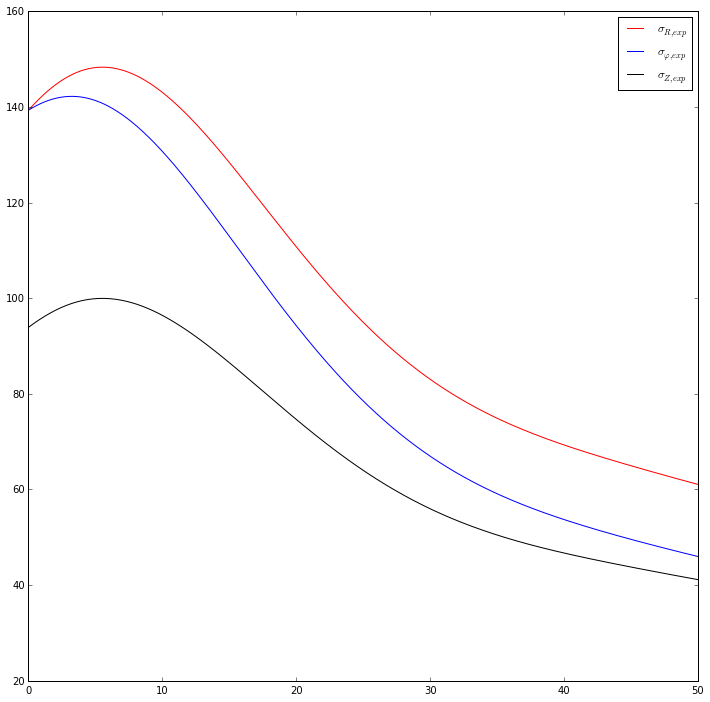

In [43]:
def sigR_exp(R):
    return sig_R_0*poly_sig_min(R)/sig_min_0

def sigZ_exp(R):
    return alpha * sigR_exp(R)

def sigPhi_exp(R):
    return sigPhi_to_sigR(R) * sigR_exp(R)


plt.plot(points, [sigR_exp(R) for R in points], '-', color='red', label='$\sigma_{R, exp}$')
plt.plot(points, [sigPhi_exp(R) for R in points], '-', color='blue', label=r'$\sigma_{\varphi, exp}$')
plt.plot(points, [sigZ_exp(R) for R in points], '-', color='black', label='$\sigma_{Z, exp}$')
plt.legend()
# plt.ylim(0, 350)
plt.xlim(0, 50)
plt.show()

И восстановим профили $\sigma_{los}^{maj}$ и $\sigma_{los}^{min}$. Связь профилей описывается следующими уравнениями: $$\sigma_{los,maj}^2=\sigma_{\varphi}^2\sin^2i+\sigma_Z^2\cos^2i$$ $$\sigma_{los,min}^2=\sigma_R^2\sin^2i+\sigma_Z^2\cos^2i$$

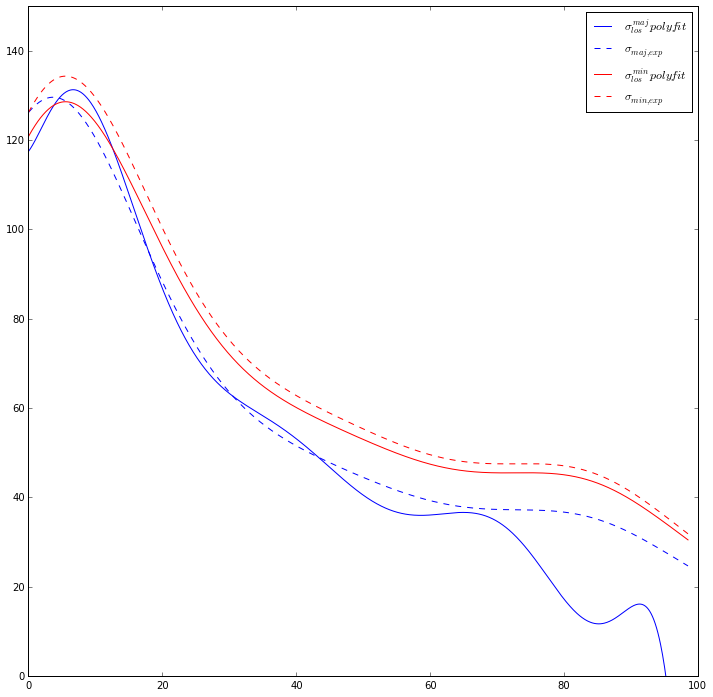

In [44]:
def sig_maj_exp(R):
    return sqrt(sigPhi_exp(R)**2 * sin(incl*pi/180)**2 + sigZ_exp(R)**2 * cos(incl*pi/180)**2)

def sig_min_exp(R):
    return sqrt(sigR_exp(R)**2 * sin(incl*pi/180)**2 + sigZ_exp(R)**2 * cos(incl*pi/180)**2)

plt.plot(points, poly_sig_maj(points), '-', label = '$\sigma_{los}^{maj} polyfit$', color='blue')
plt.plot(points, [sig_maj_exp(R) for R in points], '--', color='blue', label='$\sigma_{maj, exp}$')
plt.plot(points, poly_sig_min(points), '-', label = '$\sigma_{los}^{min} polyfit$', color='red')
plt.plot(points, [sig_min_exp(R) for R in points], '--', color='red', label='$\sigma_{min, exp}$')
plt.legend()
plt.ylim(0, 150)
plt.xlim(0, 100)
plt.show()

Финальный штрих - нанесем точки:

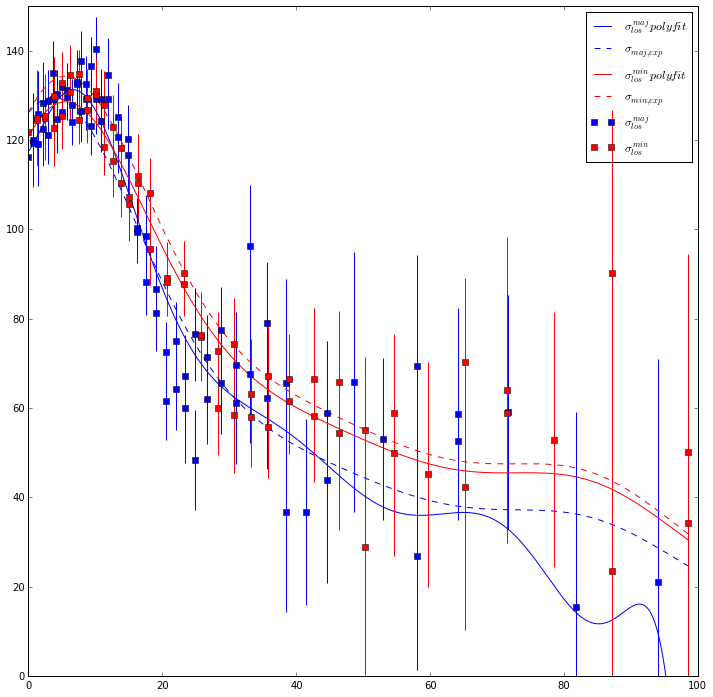

In [45]:
plt.plot(points, poly_sig_maj(points), '-', label = '$\sigma_{los}^{maj} polyfit$', color='blue')
plt.plot(points, [sig_maj_exp(R) for R in points], '--', color='blue', label='$\sigma_{maj, exp}$')
plt.plot(points, poly_sig_min(points), '-', label = '$\sigma_{los}^{min} polyfit$', color='red')
plt.plot(points, [sig_min_exp(R) for R in points], '--', color='red', label='$\sigma_{min, exp}$')
plt.plot(radii_maj, sig_maj_p, 's', label='$\sigma_{los}^{maj}$', color='blue')
plt.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='.', marker='.', mew=0, color='blue')
plt.plot(radii_min, sig_min_p, 's', label='$\sigma_{los}^{min}$', color='red')
plt.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, fmt='.', marker='.', mew=0, color='red')
plt.legend()
plt.ylim(0, 150)
plt.xlim(0, 100)
plt.show()

И посчитаем невязки для восстановленного профиля:

In [46]:
sqerr_maj_final = sum(power([sig_maj_exp(p[0]) - p[1] for p in sig_maj_data], 2))
sqerr_min_final = sum(power([sig_min_exp(p[0]) - p[1] for p in sig_min_data], 2))

print "Poly chi^2 for maj = %s, mean = %s" % (sqerr_maj_final, sqerr_maj_final / sig_maj_p.__len__())
print "Poly chi^2 for min = %s, mean = %s" % (sqerr_min_final, sqerr_min_final / sig_min_p.__len__())

Poly chi^2 for maj = 11744.7831386, mean = 156.597108515
Poly chi^2 for min = 7062.20500756, mean = 112.098492183


Теперь то, с чего надо было начинать - построим картинки для разных значений $\alpha$ и $\sigma_{R,0}$. Для того, чтобы найти где минимум, попробуем построить просто двумерные карты $\chi^2$ для разных $\sigma_{R,0}$  $\alpha$: (это очень долго, так что пересчитывать в крайнем случае) 

In [47]:
alphas = np.arange(0.1, 1.2, 0.03)
sigmas = np.arange(10.0, 300, 3.)

def compute_chi2_maps(alphas=(), sigmas=()):
    '''Вычисляем все изображения, чтобы потом только настройки менять'''
    image_min = np.random.uniform(size=(len(sigmas), len(alphas)))
    image_maj = np.random.uniform(size=(len(sigmas), len(alphas)))
    image = np.random.uniform(size=(len(sigmas), len(alphas)))
    for i,si in enumerate(sigmas):
        for j,al in enumerate(alphas):
            global alpha, sig_R_0
            alpha = al
            sig_R_0 = si
            sqerr_maj = sum(power([sig_maj_exp(p[0]) - p[1] for p in sig_maj_data], 2))/len(sig_maj_data)
            sqerr_min = sum(power([sig_min_exp(p[0]) - p[1] for p in sig_min_data], 2))/len(sig_min_data)
            sqerr_sum = 0.5*sqerr_maj+0.5*sqerr_min
            image[i][j] = sqerr_sum
            image_maj[i][j] = sqerr_maj
            image_min[i][j] = sqerr_min
    return image, image_maj, image_min

pics_path = '.cutted\\pics\\'
if not os.path.exists(pics_path):
    os.makedirs(pics_path)
if os.path.isfile(pics_path + 'chi2_map.npy'):
    image = np.load(pics_path + "chi2_map.npy")
    image_maj = np.load(pics_path + "chi2_map_maj.npy")
    image_min = np.load(pics_path + "chi2_map_min.npy")
else:
    image, image_maj, image_min = compute_chi2_maps(alphas=alphas, sigmas=sigmas)
    np.save(pics_path + 'chi2_map', image)
    np.save(pics_path + 'chi2_map_maj', image_maj)
    np.save(pics_path + 'chi2_map_min', image_min)

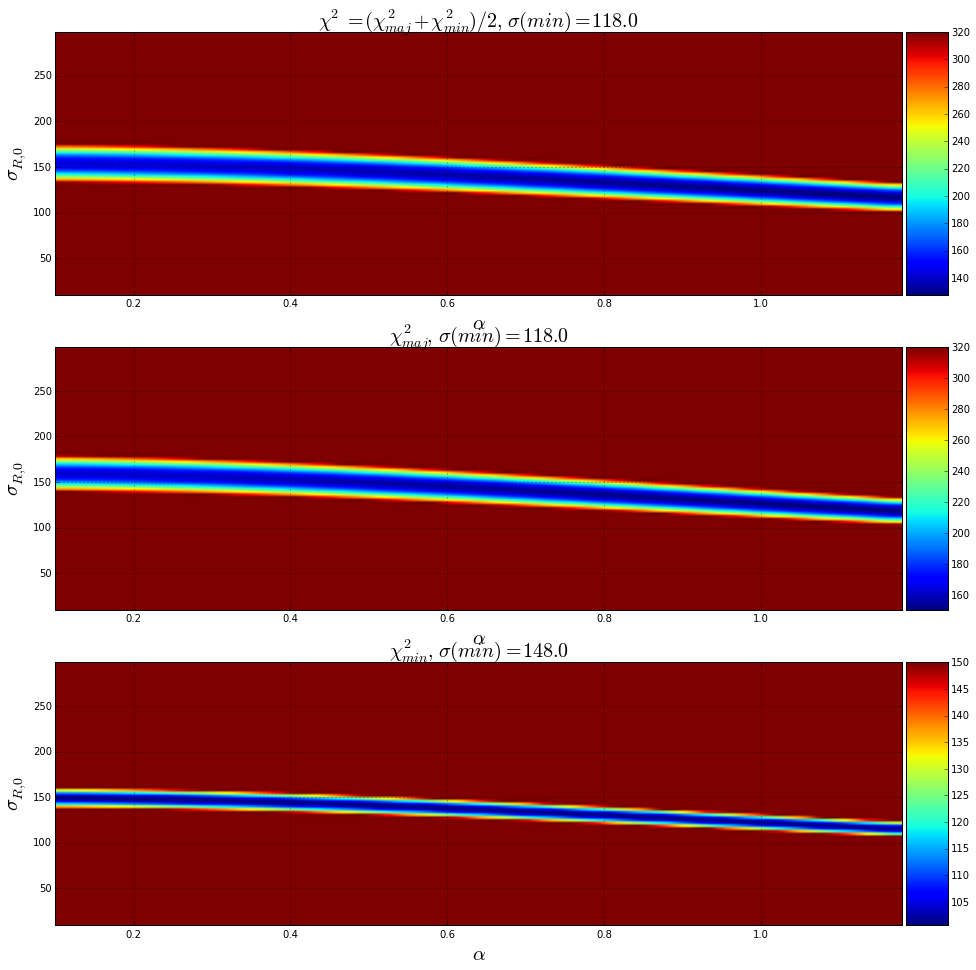

In [48]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_chi2_map(image, ax, log_scale=False, title='$\chi^2$', is_contour=False, vmax=0.):
    '''Рисуем получившиеся карты.
    Colormaps: http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps'''
    if image is not None:
        if log_scale:
            image_log = np.apply_along_axis(np.log, 1, image)
            vmax = image_log.max()
        else:
            image_log = image
        if is_contour:
            norm = cm.colors.Normalize(vmax=image.max(), vmin=-image.max())
            cmap = cm.PRGn
            levels = np.linspace(start=image_log.min(), stop=vmax, num=10)
            cset=ax.contour(image_log, levels, hold='on', colors = 'k', origin='lower', extent=[alphas[0],alphas[-1],sigmas[0],sigmas[-1]])
        im = ax.imshow(image_log, cmap='jet', vmin=image_log.min(), vmax=vmax, interpolation='spline16', 
                   origin="lower", extent=[alphas[0], alphas[-1],sigmas[0],sigmas[-1]], aspect="auto")
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        min_sigma = sigmas[int(np.where(image == image.min())[0])]        
        ax.set_title(title + '$,\ \sigma(min)=%s$' % min_sigma, size=20.)
        ax.set_ylabel('$\sigma_{R,0}$', size=20.)
        ax.set_xlabel(r'$\alpha$', size=20.)
        ax.grid(True)
 
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=False, sharey=True, figsize=[16,16])
plot_chi2_map(image, axes[0], log_scale=False, title='$\chi^2 = (\chi^2_{maj} + \chi^2_{min})/2$', is_contour=False, vmax=320.)
plot_chi2_map(image_maj, axes[1], log_scale=False, title='$\chi^2_{maj}$', is_contour=False, vmax=320.)
plot_chi2_map(image_min, axes[2], log_scale=False, title='$\chi^2_{min}$', is_contour=False, vmax=150.)
plt.show()

Видно для малой оси неплохое такое вырождение. Попробуем на этой карте взять два среза: 
- вдоль вырождения по малой оси
- вдоль профиля $\sigma_R = \frac{\sigma_{los, min}}{\sqrt{\sin^2i+\alpha^2\cos^2i}}$, т.к. именно так зависят наши параметры друг от друга (т.е. параметризация по сути однопараметрическая)
Определим для этого срез по малой оси: 

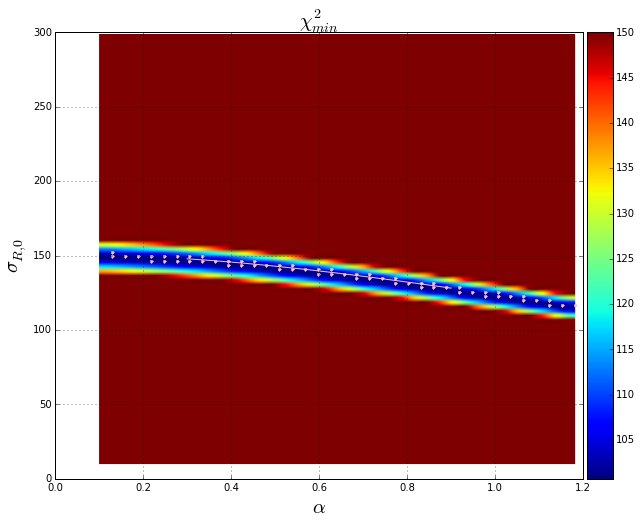

In [49]:
plt.figure(figsize=(10,8))
ax = plt.gca()
min_sigmas = np.where(image_min < image_min.min() + 3.)
slice_alph, slice_sig = min_sigmas[1], min_sigmas[0]
# видимо округление не правильное, добавляем шаг
slice_alph = map(lambda l: 0.03 + alphas[0] + (alphas[-1] - alphas[0])*l/len(image_min[0]) , slice_alph)
slice_sig = map(lambda l: 3.0 + sigmas[0] + (sigmas[-1] - sigmas[0])*l/len(image_min), slice_sig)
ax.plot(slice_alph, slice_sig, '.', color='pink')
poly_slice = poly1d(polyfit(slice_alph, slice_sig, deg=3))
im = ax.imshow(image_min, cmap='jet', vmin=image_min.min(), vmax=150., interpolation='spline16', 
           origin="lower", extent=[alphas[0], alphas[-1],sigmas[0],sigmas[-1]], aspect="auto")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title('$\chi^2_{min}$', size=20.)
ax.set_ylabel('$\sigma_{R,0}$', size=20.)
ax.set_xlabel(r'$\alpha$', size=20.)
ax.grid()
xx = np.arange(0.3, 0.9, 0.01)
ax.plot(xx, poly_slice(xx), color='pink')
plt.show()

In [50]:
cos_i, sin_i = cos(incl * pi / 180), sin(incl * pi / 180)

alphs = np.arange(0.2, 0.9, 0.01)
err_maj, err_maj_p = [], []
err_min, err_min_p = [], []
err_mean, err_mean_p = [], []
main_slice = lambda l: sig_min_0/sqrt(sin_i**2 + cos_i**2 * l**2)

for al in alphs:
    global alpha, sig_R_0
    alpha = al
    sig_R_0 = main_slice(al)
    err_maj.append(sum(power([sig_maj_exp(p[0]) - p[1] for p in sig_maj_data], 2))/len(sig_maj_data))
    err_min.append(sum(power([sig_min_exp(p[0]) - p[1] for p in sig_min_data], 2))/len(sig_min_data))
    err_mean.append(0.5*(err_maj[-1] + err_min[-1]))
    sig_R_0 = poly_slice(alpha)
    err_maj_p.append(sum(power([sig_maj_exp(p[0]) - p[1] for p in sig_maj_data], 2))/len(sig_maj_data))
    err_min_p.append(sum(power([sig_min_exp(p[0]) - p[1] for p in sig_min_data], 2))/len(sig_min_data))
    err_mean_p.append(0.5*(err_maj_p[-1] + err_min_p[-1]))

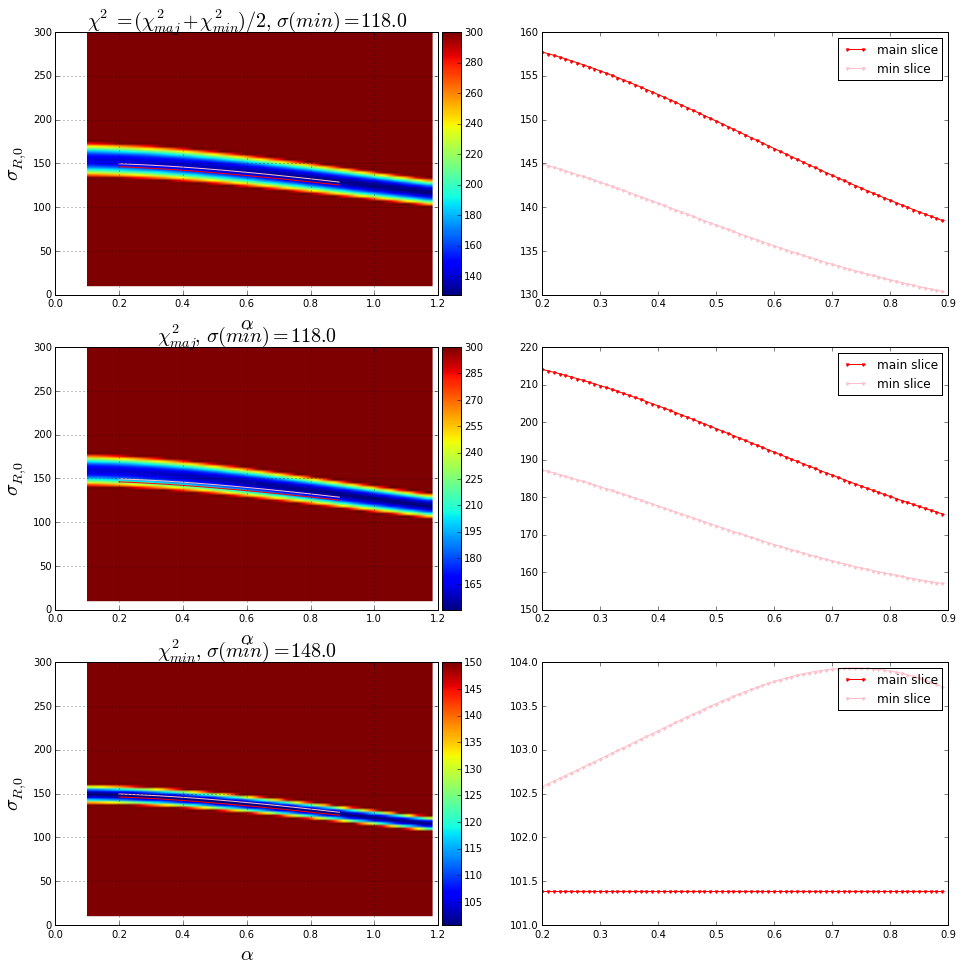

In [51]:
xx = np.arange(0.2, 0.9, 0.01)
    
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=False, sharey=False, figsize=[16,16])

plot_chi2_map(image, axes[0, 0], log_scale=False, title='$\chi^2 = (\chi^2_{maj} + \chi^2_{min})/2$', is_contour=False, vmax=300.)
axes[0,0].plot(xx, map(main_slice, xx), color='red')
axes[0,0].plot(xx, poly_slice(xx), color='pink')

axes[0, 1].plot(alphs, err_mean, '.-', label = 'main slice', color='red')
axes[0, 1].plot(alphs, err_mean_p, '.-', label = 'min slice', color='pink'); axes[0, 1].legend()

plot_chi2_map(image_maj, axes[1, 0], log_scale=False, title='$\chi^2_{maj}$', is_contour=False, vmax=300.)
axes[1,0].plot(xx, map(main_slice, xx), color='red')
axes[1,0].plot(xx, poly_slice(xx), color='pink')

axes[1, 1].plot(alphs, err_maj, '.-', label = 'main slice', color= 'red')
axes[1, 1].plot(alphs, err_maj_p, '.-', label = 'min slice', color= 'pink'); axes[1, 1].legend()

plot_chi2_map(image_min, axes[2, 0], log_scale=False, title='$\chi^2_{min}$', is_contour=False, vmax=150.)
axes[2,0].plot(xx, map(main_slice, xx), color='red')
axes[2,0].plot(xx, poly_slice(xx), color='pink')

axes[2, 1].plot(alphs, err_min, '.-', label = 'main slice', color= 'red')
axes[2, 1].plot(alphs, err_min_p, '.-', label = 'min slice', color='pink'); axes[2, 1].legend()

plt.show()

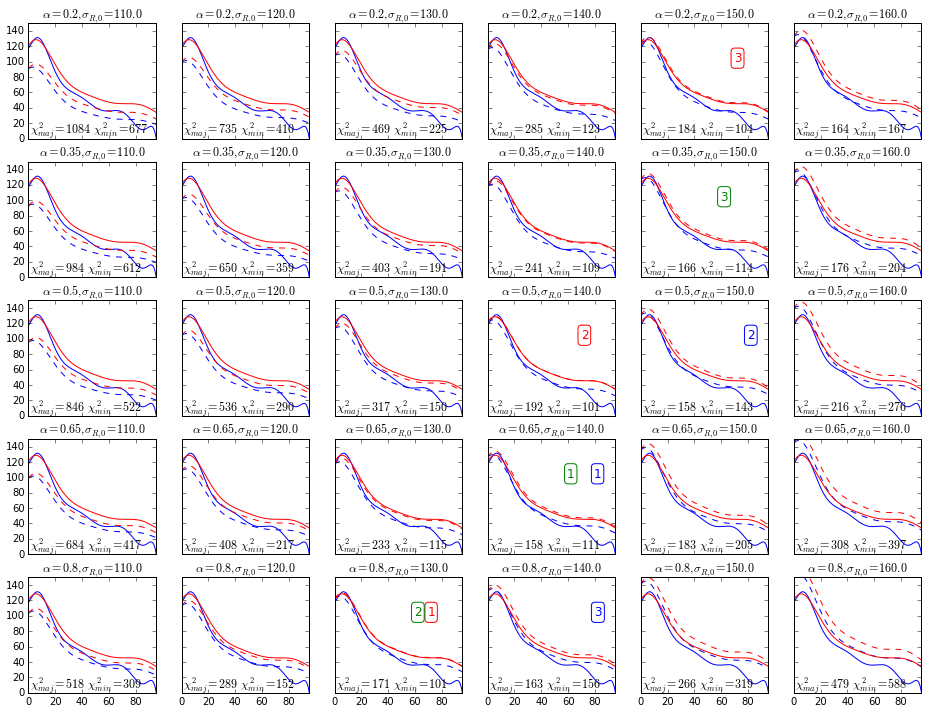

In [52]:
# Перебор alpha
alphas = np.arange(0.2, 0.95, 0.15)

# Перебор sig_R_0
sigmas = np.arange(110., 170., 10.)

# Те картинки, на которые стоит обратить особое внимание
good_pics = []

def plot_ranges(sigmas_range, alphas_range, good_pics=[], calc_chi=False, best_err=3):
    '''
    Для всех предложенных вариантов sigR и alpha
    рисует графики исходных и восстановленных дисперсий скоростей los.
    Если calc_chi = True, то также считает ошибку по наблюдаемым точкам.
    Если ошибка считается, то отмечаются best_err лучших (наименьших) результата.
    Синий - для большой оси, красный - малой, зеленый - полусумма.
    Изменяет глобальные значения sig_R_0 и alpha!'''
    nrows = alphas.size
    ncols = sigmas.size
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=[16,12])
    plt_index = 0
    # Последнее - среднее геометрическое
    sqerr_majs, sqerr_mins, sqerr_mean = [],[],[]
    for al in alphas_range:
        for si in sigmas_range:
            global alpha, sig_R_0
            alpha = al
            sig_R_0 = si
            ax = axes[plt_index/ncols, plt_index % ncols]
            ax.set_title(r'$\alpha = %s, \sigma_{R,0}=%s$' % (al,si))
            ax.plot(points, poly_sig_maj(points), '-', color='blue')
            ax.plot(points, [sig_maj_exp(Rr) for Rr in points], '--', color='blue')
            ax.plot(points, poly_sig_min(points), '-', color='red')
            ax.plot(points, [sig_min_exp(R) for R in points], '--', color='red')
            if calc_chi:
                sqerr_maj = sum(power([sig_maj_exp(p[0]) - p[1] for p in sig_maj_data], 2))/len(sig_maj_data)
                sqerr_min = sum(power([sig_min_exp(p[0]) - p[1] for p in sig_min_data], 2))/len(sig_min_data)
                ax.text(1, 5, "$\chi^2_{maj}=%5.0f\, \chi^2_{min}=%5.0f$" % (sqerr_maj, sqerr_min), fontsize=12)
                sqerr_majs.append(sqerr_maj);sqerr_mins.append(sqerr_min)
                sqerr_mean.append(0.5*sqerr_maj+0.5*sqerr_min)
            ax.set_ylim(0, 150)
            ax.set_xlim(0, 95)
            if (plt_index/ncols, plt_index % ncols) in good_pics:
                ax.plot([40], [200], 'o', markersize=12., color=(0.2,1.0,0.))
            plt_index = plt_index + 1
    if calc_chi:
        best_maj_err = heapq.nsmallest(best_err, sqerr_majs)
        for b_maj in best_maj_err:
            b_maj_ind = sqerr_majs.index(b_maj)
            ax = axes[b_maj_ind/ncols, b_maj_ind % ncols]
            #ax.plot([35], [200], 'o', markersize=12., color='b')
            ax.text(80, 100, "%s" % (best_maj_err.index(b_maj)+1), fontsize=12, color='b', 
                    bbox=dict(facecolor='none', edgecolor='b', boxstyle='round'))
        best_min_err = heapq.nsmallest(best_err, sqerr_mins)
        for b_min in best_min_err:
            b_min_ind = sqerr_mins.index(b_min)
            ax = axes[b_min_ind/ncols, b_min_ind % ncols]
            #ax.plot([30], [200], 'o', markersize=12., color='r')
            ax.text(70, 100, "%s" % (best_min_err.index(b_min)+1), fontsize=12, color='r', 
                    bbox=dict(facecolor='none', edgecolor='r', boxstyle='round'))
        best_mean_err = heapq.nsmallest(best_err, sqerr_mean)
        for b_mean in best_mean_err:
            b_mean_ind = sqerr_mean.index(b_mean)
            ax = axes[b_mean_ind/ncols, b_mean_ind % ncols]
            #ax.plot([25], [200], 's', markersize=12., color='g')
            ax.text(60, 100, "%s" % (best_mean_err.index(b_mean)+1), fontsize=12, color='g', 
                    bbox=dict(facecolor='none', edgecolor='g', boxstyle='round'))

plot_ranges(sigmas, alphas, good_pics=good_pics, calc_chi=True)
plt.show()

Карты из ассиметричного дрифта:

In [53]:
def log_deriv(R):
    """Вычисление логарифмической производной sig_R,
    для ассиметричного сдвига - как описано выше"""
    return 2*R * poly_marj_R.deriv()(R) / poly_marj_R(R)

#Масштаб диска в секундах (из диплома, непротиворечивая)
h_d = 21.5
print "h_d = %s" % h_d

def asym_drift_value(R):
    """Вычисляем величину сдвига между квадратами скоростей газа и звезд"""
    return poly_marj_R(R)**2 * (sigPhi_to_sigR(R)**2 - 1 + R/h_d - log_deriv(R))

predict_drift = lambda l: asym_drift_value(l) + poly_star(l)**2 
predict_gas = lambda l: sqrt(predict_drift(l)) if predict_drift(l) > 0 else np.nan

h_d = 21.5


In [54]:
#От альфа не зависит
alpha = 0.5
sigmas = np.arange(50.0, 350, 2.)

def compute_chi2_drift(sigmas=()):
    result_err = []
    for i,si in enumerate(sigmas):
        global sig_R_0, poly_marj_R
        sig_R_0 = si
        #Приближаем полиномом для подсчета производной
        poly_marj_R = poly1d(polyfit(points, [sigR_exp(R) for R in points], deg=11))
        sqerr = sum(power([predict_gas(p[0]) - p[1] for p in filter(lambda l: l[0] < 100, wsrt_raw_data)], 2))/len(wsrt_raw_data)
        result_err.append(sqerr)
    return result_err

drift_err = compute_chi2_drift(sigmas=sigmas)

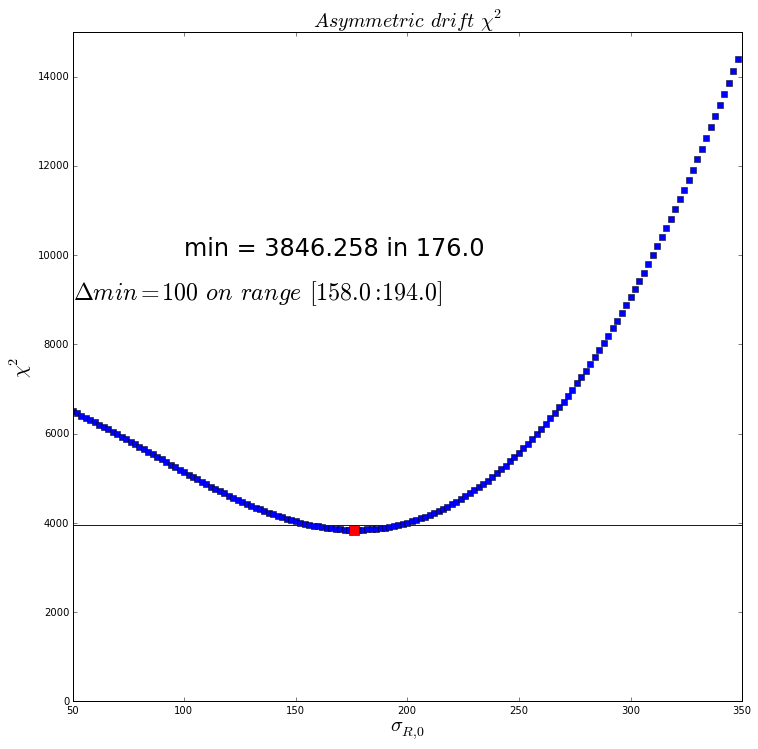

In [55]:
def plot_chi2_drift(sigmas, drifts):
    plt.plot(sigmas, drifts, 's')
    ind = drifts.index(min(drifts))
    value = drifts[ind]
    plt.plot(sigmas[ind], value, 's', color='red', ms=10.)
    plt.title('$Asymmetric\, drift\, \chi^2$', size=20.)
    plt.xlabel('$\sigma_{R,0}$', size=20.)
    plt.ylabel('$\chi^2$', size=20.)
    plt.ylim(0, 15000)
    plt.text(100, 10000, 'min = %.3f in %s' % (value, sigmas[ind]), size = 24.)
    plt.axhline(y=value+100)
    accep_val = filter(lambda l: l < value+100, drifts)
    ind_l = drifts.index(accep_val[0]); ind_r = drifts.index(accep_val[-1])
    plt.text(50, 9000, '$\Delta min=100\, on\, range\, [%s:%s]$' %(sigmas[ind_l], sigmas[ind_r]) , size = 24.)
    plt.show()
    

plot_chi2_drift(sigmas, drift_err)

Есть четкий минимум, но он лежит на довольно плоском плато, что на самом деле хорошо для нас - можно включить туда нужный промежуток. Хотя конечно данные WSRT - хуже некуда. 

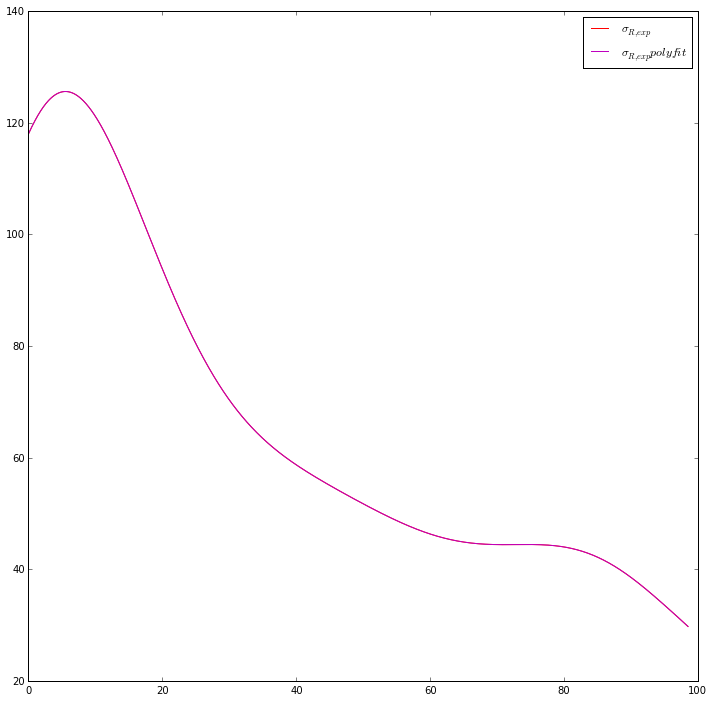

In [56]:
sig_R_0 = 118.
poly_marj_R = poly1d(polyfit(points, [sigR_exp(R) for R in points], deg=11))
plt.plot(points, [sigR_exp(R) for R in points], '-', color='red', label='$\sigma_{R, exp}$')
plt.plot(points, [poly_marj_R(R) for R in points], '-', color='m', label='$\sigma_{R, exp} polyfit$')
plt.legend()
plt.show()

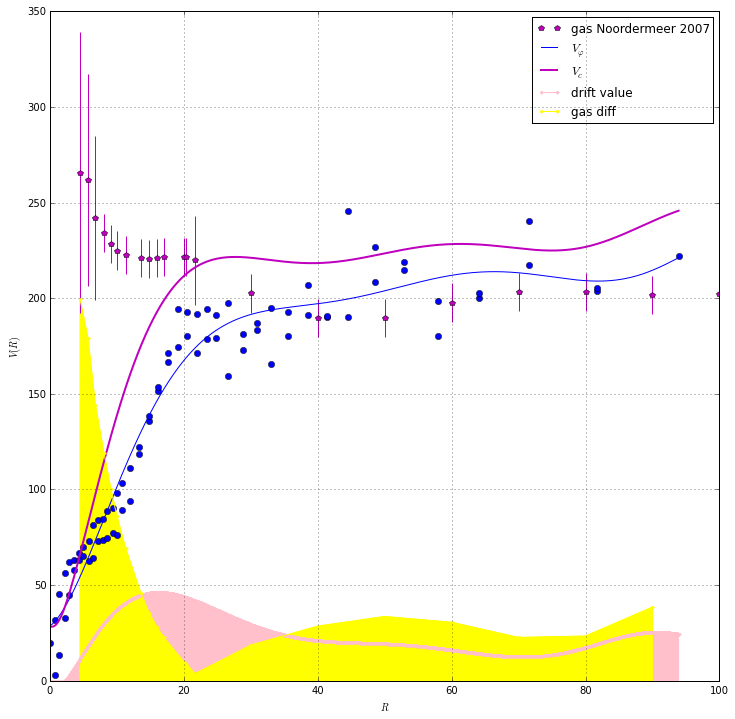

In [57]:
plt.plot(r_wsrt, vel_wsrt, 'p', label="gas Noordermeer 2007", color='m')
plt.errorbar(r_wsrt, vel_wsrt, yerr=e_vel_wsrt, fmt='.', marker='.', mew=0, color='m')

plt.plot(r_ma_b, vel_ma_b, 'o', color='blue', markersize=6)
plt.plot(test_points, poly_star(test_points), '-', color='blue', label=r'$V_{\varphi}$')
predict_drift = lambda l: asym_drift_value(l) + poly_star(l)**2 
predict_gas = lambda l: sqrt(predict_drift(l)) if predict_drift(l) > 0 else -100
plt.plot(test_points, [predict_gas(R) for R in test_points], 
         '-', color='m', label=r'$V_c$', lw=2.)
plt.xlabel('$R$'); plt.ylim(0)
plt.ylabel('$V(R)$')
plt.ylim(0, 350)
plt.xlim(0, 100)

ad = [sqrt(asym_drift_value(R) + poly_star(R)**2) for R in test_points]
dif = [(ad[i] - poly_star(test_points[i])) for i in range(test_points.__len__())]
plt.plot(test_points, dif, marker='.', lw=1, color = 'pink', label = 'drift value')
plt.fill_between(test_points, 0, dif, color = 'pink')

dif2 = [abs(sqrt(asym_drift_value(R) + poly_star(R)**2)-vel_wsrt[np.where(r_wsrt==R)[0][0]]) for R in filter(lambda l: l < 100, r_wsrt)]
plt.plot(filter(lambda l: l < 100, r_wsrt), dif2, marker='.', lw=1, color = 'yellow', label = 'gas diff')
plt.fill_between(filter(lambda l: l < 100, r_wsrt), 0, dif2, color = 'yellow')

plt.grid()
plt.legend()
plt.show()

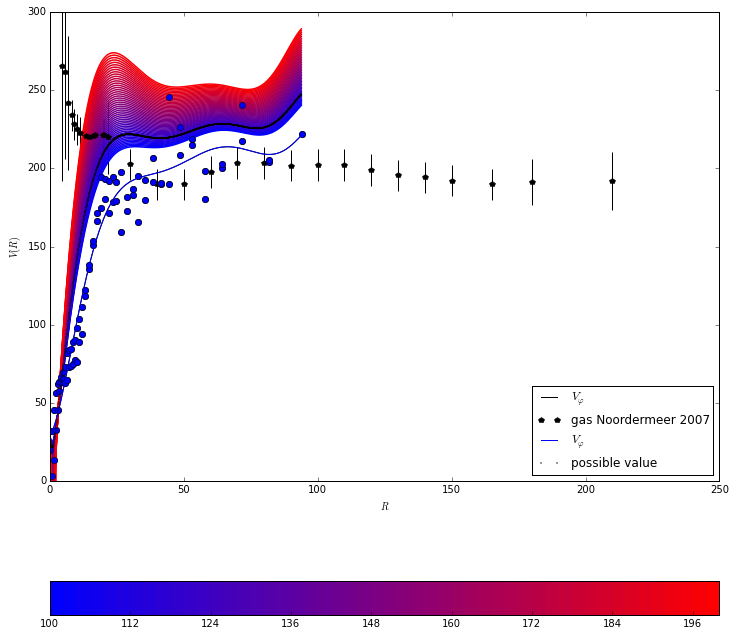

In [63]:
import matplotlib

min_s, max_s = (100., 200.)
step_s = 2.
sigmas = np.arange(min_s, max_s, step_s)
mymap = matplotlib.colors.LinearSegmentedColormap.from_list('mycolors',['blue','red'])
Z = [[0,0],[0,0]]
levels = np.arange(min_s, max_s + step_s, step_s)
CS3 = plt.contourf(Z, levels, cmap=mymap)
plt.clf()

plt.plot(r_ma_b, vel_ma_b, 'o', color='black', markersize=6)
plt.plot(test_points, poly_star(test_points), '-', color='black', label=r'$V_{\varphi}$')
plt.xlabel('$R$')
plt.ylabel('$V(R)$')
plt.ylim(0, 300)

for s in sigmas:
    sig_R_0 = s
    poly_marj_R = poly1d(polyfit(points, [sigR_exp(R) for R in points], deg=7))
    ind = np.where(sigmas==s)[0][0]
    plt.plot(test_points, [predict_gas(R) for R in test_points], 
     '-', lw=1.5, ms=0.5, color=mymap(ind*1.0/len(sigmas)))

plt.colorbar(CS3, orientation='horizontal')
    
plt.plot(r_wsrt, vel_wsrt, 'p', label="gas Noordermeer 2007", color='black')
plt.errorbar(r_wsrt, vel_wsrt, yerr=e_vel_wsrt, fmt='.', marker='.', mew=0, color='black')
plt.plot(r_ma_b, vel_ma_b, 'o', color='blue', markersize=6)
plt.plot(test_points, poly_star(test_points), '-', color='blue', label=r'$V_{\varphi}$')
    
sig_R_0 = 118.
poly_marj_R = poly1d(polyfit(points, [sigR_exp(R) for R in points], deg=7))
plt.plot(test_points, [predict_gas(R) for R in test_points], 
     'o', label='possible value', color='black', mfc='none', markersize=1)

plt.legend(loc='lower right')
plt.show()

Удалось найти одну довольно древнюю статью с данными по газу: http://adsabs.harvard.edu/abs/1991A%26A...245....7V

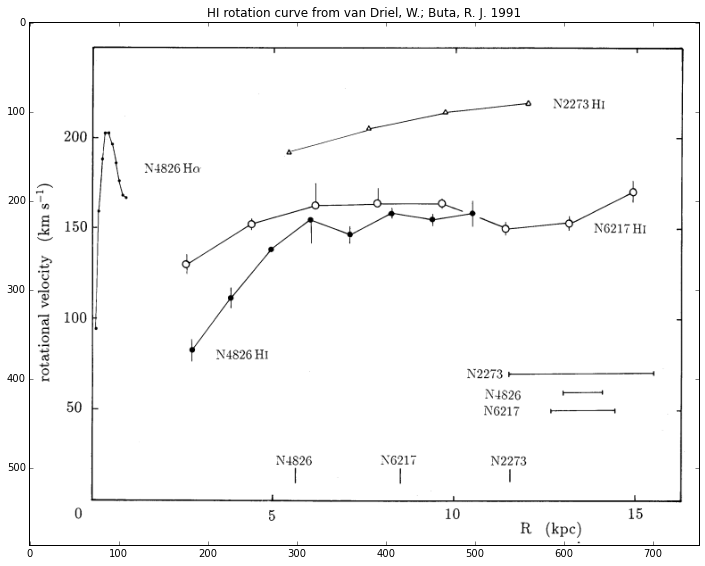

In [64]:
os.chdir("C:\\science\\2FInstability\\data\\ngc2273")

plt.imshow(np.asarray(Image.open("Driel91.png")))
plt.title("HI rotation curve from van Driel, W.; Buta, R. J. 1991")
plt.show()

Дальность в статье - 22.4 Mпк, у нас из NED - 28.5 и масштаб 0.138 кпк/". Соответственно чтобы кпк на картинке пересчитать в секунды, надо их поделить на 22.4/28.5*0.138 = 0.108 кпк/".

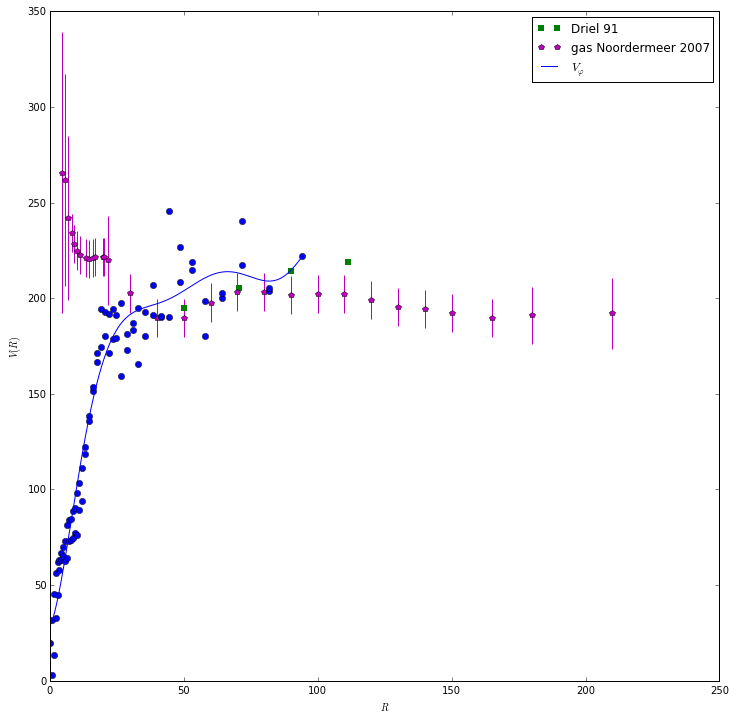

In [65]:
#Снятые с графика данные:
driel_HI_px_data = ((219, 396), (309, 417), (394, 435), (487, 444))

def corr_driel(x):
    ''' px, px -> ", km/s
    607 px = 15 kpc, 406 px = 200 km/s'''
    return (x[0]/607.*15./0.108, x[1]/406.*200.)

driel_HI_g_data = map(corr_driel, driel_HI_px_data)
r_driel, vel_driel = zip(*driel_HI_g_data)

plt.plot(r_driel, vel_driel, 's', label = 'Driel 91', color= 'g', mew=0)

plt.plot(r_wsrt, vel_wsrt, 'p', label="gas Noordermeer 2007", color='m')
plt.errorbar(r_wsrt, vel_wsrt, yerr=e_vel_wsrt, fmt='.', marker='.', mew=0, color='m')

plt.plot(r_ma_b, vel_ma_b, 'o', color='blue', markersize=6)
plt.plot(test_points, poly_star(test_points), '-', color='blue', label=r'$V_{\varphi}$')
plt.xlabel('$R$'); plt.ylim(0)
plt.ylabel('$V(R)$')
plt.ylim(0, 350)
plt.legend()
plt.show()

На удивление похоже на данные Ноордермеера. 

In [68]:
import plotly.plotly as py
from plotly.graph_objs import *

# x1 = y1 = np.arange(-1,1,0.4)
# yt1 = x1[:,np.newaxis]
# x = y = np.arange(-5,5,0.1)
# yt = x[:,np.newaxis]
# z = np.cos(x*yt)+np.sin(x*yt)
x,y,z = [],[],[]

alphas = np.arange(0.2, 0.9, 0.03)
sigmas = np.arange(50.0, 300, 3.)

for i,si in enumerate(sigmas):
    for j,al in enumerate(alphas):
            global alpha, sig_R_0
            alpha = al
            sig_R_0 = si
            sqerr_maj = sum(power([sig_maj_exp(p[0]) - p[1] for p in sig_maj_data], 2))/len(sig_maj_data)
            sqerr_min = sum(power([sig_min_exp(p[0]) - p[1] for p in sig_min_data], 2))/len(sig_min_data)
            sqerr_sum = 0.5*sqerr_maj+0.5*sqerr_min
            z.append(sqerr_sum)
x = sigmas
y = map(lambda l: l*100, alphas)
z = np.reshape(z, (len(y), len(x)))
            
py.sign_in('amarch', 'aei5u1zuls')

In [69]:
print len(z[0]), len(x), len(y)

84 84 24


In [70]:
%%capture
# capture to suppress help() output
# remeber you can always call help on Plotly objects
help(Surface)

In [71]:
# aquatic colorscale
cls=[[0, 'rgb(0,0,131)'], [0.125, 'rgb(0,60,170)'], [0.375, 'rgb(5,255,255)'], [0.625, 'rgb(255,255,0)'], 
     [0.875, 'rgb(250,0,0)'], [1, 'rgb(128,0,0)']]

data = Data([ Surface( x=x[::10], y=y[::10], z=z[::10], colorscale=cls ) ])

layout = Layout(
    title='3d',
    autosize=True,
    scene=Scene( 
        zaxis=ZAxis(range=[0, 400],domain=[0, 400],autorange=False,nticks=10,gridcolor='rgb(255, 255, 255)',
                    gridwidth=2,zerolinecolor='rgb(255, 255, 255)',zerolinewidth=2),
        xaxis=XAxis(nticks=10,gridcolor='rgb(255, 255, 255)',gridwidth=2,zerolinecolor='rgb(255, 255, 255)',zerolinewidth=2),   
        yaxis=YAxis(nticks=10,gridcolor='rgb(255, 255, 255)',gridwidth=2,zerolinecolor='rgb(255, 255, 255)',zerolinewidth=2),        
        bgcolor="rgb(244, 244, 248)"
    )
)

fig = Figure(data=data, layout=layout)

# As of Plotly's python package plotly-1.5.0
# 2d contours in 3d plots aren't supported, 
# but you can hack them in like this.
# Stayed tuned for updates.
contours = { 'z':{ 'show':True } }
fig['data'][0]['contours'] = contours

# validate = False prevents syntax checking that would complain about the 2d contour hack (see above)
py.iplot(fig, filename='3d', validate=False)

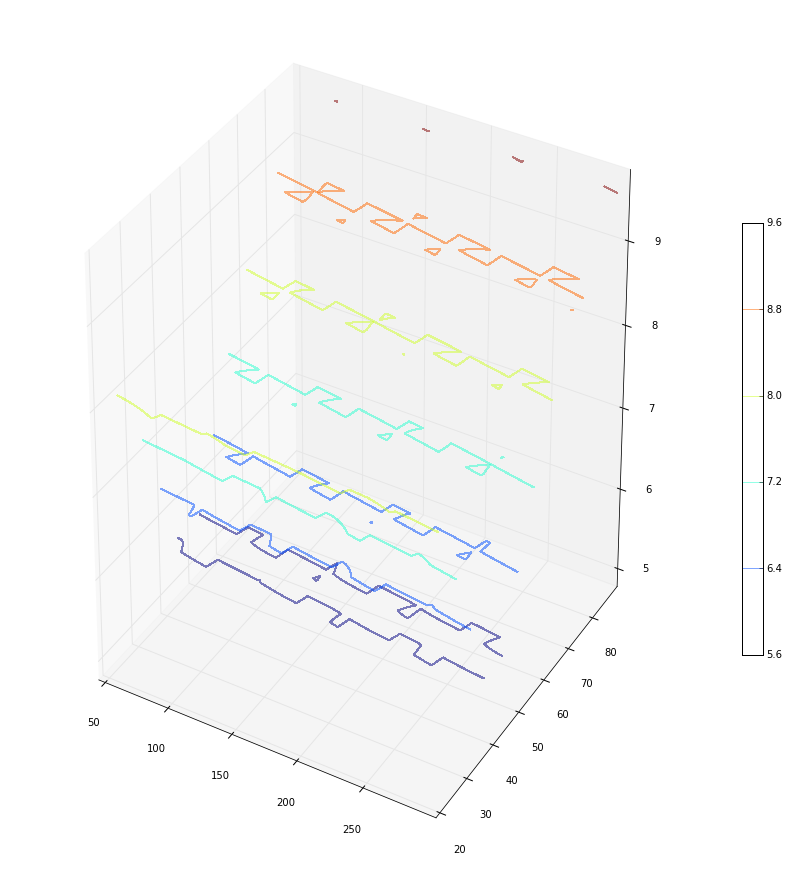

In [78]:
import random
from mpl_toolkits.mplot3d import axes3d, Axes3D
fig = plt.figure()

ax = Axes3D(fig)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# x = y = np.arange(-3.0, 3.0, 0.05)
X, Y = np.meshgrid(x, y)
Z = map(np.log, z)

p = ax.contour(X, Y, Z, rstride=4, cstride=4, linewidth=0, antialiased=False, alpha=0.5)
# p = ax.plot_surface(X, Y, Z, rstride=4, cstride=4, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.5)
# ax.view_init(30, -25)

# ax.set_xlabel('sigmas')
# ax.set_ylabel('100*alpha')
# ax.set_zlabel('Z Label')

cb = fig.colorbar(p, shrink=0.5)

plt.show()

# from mpl_toolkits.mplot3d import axes3d, Axes3D
# fig = plt.figure()

# ax = Axes3D(fig)

# X, Y, Z = axes3d.get_test_data(0.05)
# cset = ax.contour(X, Y, Z, rstride=4, cstride=4, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.5)
# ax.clabel(cset, fontsize=9, inline=1)
# plt.show()

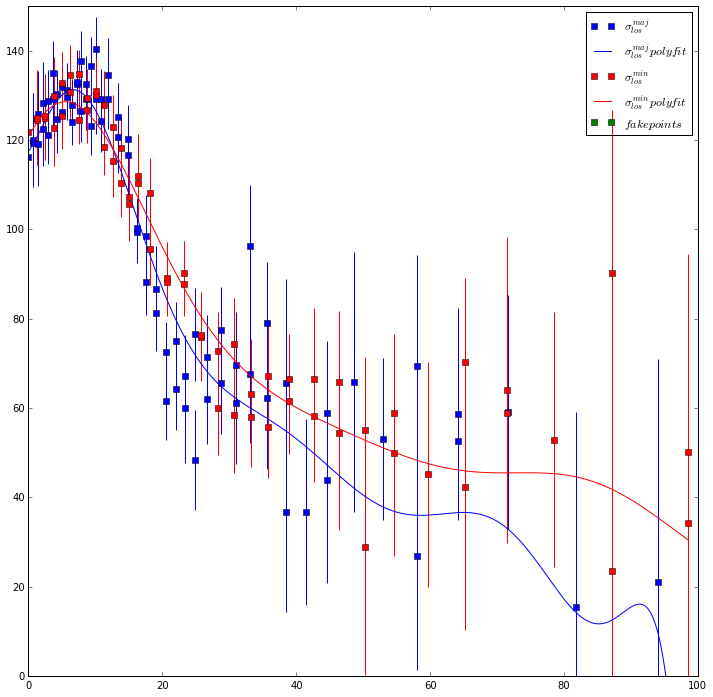

In [79]:
fig = plt.figure()
plt.plot(radii_maj, sig_maj_p, 's', label='$\sigma_{los}^{maj}$', color='blue')
plt.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='.', marker='.', mew=0, color='blue')
plt.plot(points, poly_sig_maj(points), label = '$\sigma_{los}^{maj} polyfit$', color='blue')
plt.plot(radii_min, sig_min_p, 's', label='$\sigma_{los}^{min}$', color='red')
plt.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, fmt='.', marker='.', mew=0, color='red')
plt.plot(points, poly_sig_min(points), label = '$\sigma_{los}^{min} polyfit$', color='red')
plt.plot(fake_radii, fake_sig, 'bs', color='green', label='$fake points$')
plt.legend()
plt.ylim(0,150)

plt.savefig('n2273_sbezier\\' + pics_path + 'destination_path.eps', format='eps', dpi=1000)